### Setup

In [37]:
import yfinance
import datetime as dt
import json
import pandas as pd
import requests
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
plt.rcParams["figure.figsize"] = (15,8)

In [5]:
btc = pd.read_csv('Datasets\BTC-USD.csv')

In [6]:
btc.set_index('Date', inplace=True)

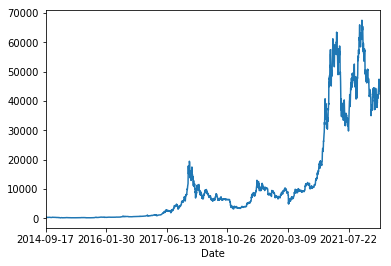

In [7]:
btc['Close'].plot()

In [21]:
rates = pd.read_csv('Datasets\Interest rates\daily-treasury-rates.csv')

In [22]:
rates = rates[['3 Mo', '10 Yr', 'Date']].set_index('Date').sort_index()
#rates[rates.isna().any(axis=1)]

In [45]:
rates.index = pd.to_datetime(rates.index)
btc.index = pd.to_datetime(btc.index)

In [54]:
btc = btc.join(rates, how='inner')

In [56]:
btc.head()

,Open,High,Low,Close,Adj Close,Volume,3 Mo,10 Yr
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,0.02,2.62
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,0.02,2.63
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,0.02,2.59
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600,0.01,2.57
2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500,0.01,2.54


### Functions

In [23]:
def returns_plot(s, w):
    signal = s.pct_change(w).dropna()
    m = np.abs(signal).mean()
    sd = np.abs(signal).std()
    print(f'mean absolute pct return: {round(m*100, 2)}%')
    print(f'sd absolute pct return: {round(sd*100, 2)}%')
    signal.hist(bins=100)
    plt.axvline(m, color='red')
    plt.show()

In [24]:
def common_idx(df1, df2):
    """
    This function finds the intersection of the indices of two signals

    Parameters:
        df1 (pandas DataFrame): DataFrame containing signal 1
        df2 (pandas DataFrame): DataFrame containing singal 2

    Returns:
        DataFrames containing signals with common indices
    """
    
    comm_idx = df1.index.intersection(df2.index)
    
    df1 = df1.loc[comm_idx]
    df2 = df2.loc[comm_idx]

    return(df1, df2)

In [25]:
def rolling_model(X, y, tw=252, yw=5):
    """
    This function trains a regression model using a rolling window

    Parameters:
        X (pandas DataFrame): DataFrame containing predictors
        y (pandas DataFrame): DataFrame containing output
        tw (int): backward rolling window to train model over
        yw (int): forward looking rolling window for output

    Returns:
        list of R-squared scores
    """   

    actual = []
    pred = []
    i = 0
    
    start_time = timeit.default_timer()
    
    while (i+tw+yw) <= (len(X)-1):
        X_sub = X[i:(i+tw)]
        y_sub = y[i:(i+tw)]
        reg = LinearRegression().fit(X_sub, y_sub)
        
        pred.append(reg.predict(np.array(X.iloc[i+tw+yw]).reshape(1, -1))[0])
        actual.append(y.iloc[i+tw+yw])
        
        i += 1
        
    elapsed = timeit.default_timer() - start_time

    print(f'Run time (mins): {round(elapsed/60, 2)}')
    
    res_df = pd.DataFrame({'actual':actual,'pred':pred})
    r2 = (np.corrcoef(res_df['actual'], res_df['pred'])[0][1])**2
    
    print(f'# of models: {len(res_df)}')   
    print(f'r2: {round(r2, 3)}')
    
    plt.scatter(res_df['actual'], res_df['pred'])
    plt.xlabel('actual', fontsize=16)
    plt.ylabel('pred', fontsize=16)
    plt.show()
        
    return res_df

### Explore returns by window length

mean absolute pct return: 2.56%
sd absolute pct return: 2.92%


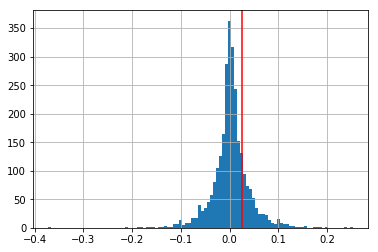

In [26]:
# daily returns
returns_plot(btc['Close'], 1)

mean absolute pct return: 6.34%
sd absolute pct return: 6.11%


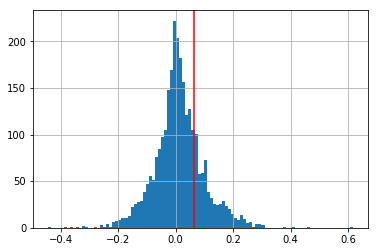

In [27]:
# weekly returns
returns_plot(btc['Close'], 5)

mean absolute pct return: 9.47%
sd absolute pct return: 9.02%


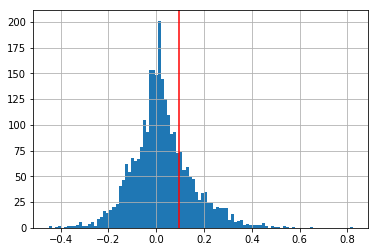

In [28]:
# bi-weekly returns
returns_plot(btc['Close'], 10)

mean absolute pct return: 14.64%
sd absolute pct return: 14.39%


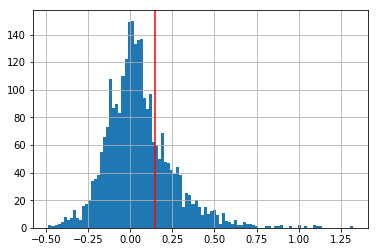

In [29]:
# monthly returns
returns_plot(btc['Close'], 20)

mean absolute pct return: 32.2%
sd absolute pct return: 33.32%


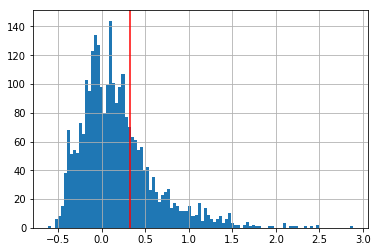

In [30]:
# quarterly returns
returns_plot(btc['Close'], 60)

### Feature engineering

In [31]:
# train-test split
X_train = btc[['Close', 'Volume']]

y_train = pd.DataFrame(btc['Close'])

In [32]:
# construct features
dayofweek = pd.get_dummies(pd.to_datetime(X.index).dayofweek, drop_first=True)
dayofweek.rename(columns={1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}, inplace=True)
X = pd.concat([X, dayofweek.set_index(X.index)], axis=1)

# log returns
X['log_ret_1'] = np.log(X['Close']).diff()
X['log_ret_5'] = np.log(X['Close']).diff(5)
X['log_ret_20'] = np.log(X['Close']).diff(20)
X['log_ret_60'] = np.log(X['Close']).diff(60)

# rolling mean
X['log_ret_1_mean_5'] = np.log(X['Close']).diff().rolling(5).mean()
X['log_ret_5_mean_5'] = np.log(X['Close']).diff(5).rolling(5).mean()
X['log_ret_20_mean_5'] = np.log(X['Close']).diff(20).rolling(5).mean()
X['log_ret_60_mean_5'] = np.log(X['Close']).diff(60).rolling(5).mean()

X['log_ret_1_mean_20'] = np.log(X['Close']).diff().rolling(20).mean()
X['log_ret_5_mean_20'] = np.log(X['Close']).diff(5).rolling(20).mean()
X['log_ret_20_mean_20'] = np.log(X['Close']).diff(20).rolling(20).mean()
X['log_ret_60_mean_20'] = np.log(X['Close']).diff(60).rolling(20).mean()

X['log_ret_1_mean_60'] = np.log(X['Close']).diff().rolling(60).mean()
X['log_ret_5_mean_60'] = np.log(X['Close']).diff(5).rolling(60).mean()
X['log_ret_20_mean_60'] = np.log(X['Close']).diff(20).rolling(60).mean()
X['log_ret_60_mean_60'] = np.log(X['Close']).diff(60).rolling(60).mean()

# rolling std
X['log_ret_1_std_30'] = np.log(X['Close']).diff().rolling(30).std()
X['log_ret_5_std_30'] = np.log(X['Close']).diff(5).rolling(30).std()
X['log_ret_20_std_30'] = np.log(X['Close']).diff(20).rolling(30).std()
X['log_ret_60_std_30'] = np.log(X['Close']).diff(60).rolling(30).std()

X['log_ret_1_std_60'] = np.log(X['Close']).diff().rolling(60).std()
X['log_ret_5_std_60'] = np.log(X['Close']).diff(5).rolling(60).std()
X['log_ret_20_std_60'] = np.log(X['Close']).diff(20).rolling(60).std()
X['log_ret_60_std_60'] = np.log(X['Close']).diff(60).rolling(60).std()

# rolling min
X['log_ret_1_min_30'] = np.log(X['Close']).diff().rolling(30).min()
X['log_ret_5_min_30'] = np.log(X['Close']).diff(5).rolling(30).min()
X['log_ret_20_min_30'] = np.log(X['Close']).diff(20).rolling(30).min()
X['log_ret_60_min_30'] = np.log(X['Close']).diff(60).rolling(30).min()

X['log_ret_1_min_60'] = np.log(X['Close']).diff().rolling(60).min()
X['log_ret_5_min_60'] = np.log(X['Close']).diff(5).rolling(60).min()
X['log_ret_20_min_60'] = np.log(X['Close']).diff(20).rolling(60).min()
X['log_ret_60_min_60'] = np.log(X['Close']).diff(60).rolling(60).min()

# rolling max
X['log_ret_1_max_30'] = np.log(X['Close']).diff().rolling(30).max()
X['log_ret_5_max_30'] = np.log(X['Close']).diff(5).rolling(30).max()
X['log_ret_20_max_30'] = np.log(X['Close']).diff(20).rolling(30).max()
X['log_ret_60_max_30'] = np.log(X['Close']).diff(60).rolling(30).max()

X['log_ret_1_max_60'] = np.log(X['Close']).diff().rolling(60).max()
X['log_ret_5_max_60'] = np.log(X['Close']).diff(5).rolling(60).max()
X['log_ret_20_max_60'] = np.log(X['Close']).diff(20).rolling(60).max()
X['log_ret_60_max_60'] = np.log(X['Close']).diff(60).rolling(60).max()

X.dropna(inplace=True)

X.drop(columns=['Close', 'Volume'], axis=1, inplace=True)

In [34]:
# construct output
y['log_ret_1'] = np.log(y['Close']).diff(1).shift(-1)
y['log_ret_5'] = np.log(y['Close']).diff(5).shift(-5)
y['log_ret_10'] = np.log(y['Close']).diff(10).shift(-10)
y['log_ret_20'] = np.log(y['Close']).diff(20).shift(-20)

y.dropna(inplace=True)
y.drop(columns=['Close'], axis=1, inplace=True)

In [36]:
X, y = common_idx(X, y)

X.shape, y.shape

((2159, 46), (325, 46), (2159, 4), (325, 4))

In [33]:
X_train.shape, X_test.shape

((2179, 46), (345, 46))

In [35]:
y_train.shape, y_test.shape

((2278, 4), (444, 4))

### GBR model

In [38]:
reg = GradientBoostingRegressor(random_state=10, n_estimators=100)
reg.fit(X_train, y_train['log_ret_5'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=10, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
np.corrcoef(reg.predict(X_train), y_train['log_ret_5'])[0][1]

0.8356504263868818

In [40]:
# overfit
np.corrcoef(reg.predict(X_test), y_test['log_ret_5'])[0][1]

0.20711841802160116

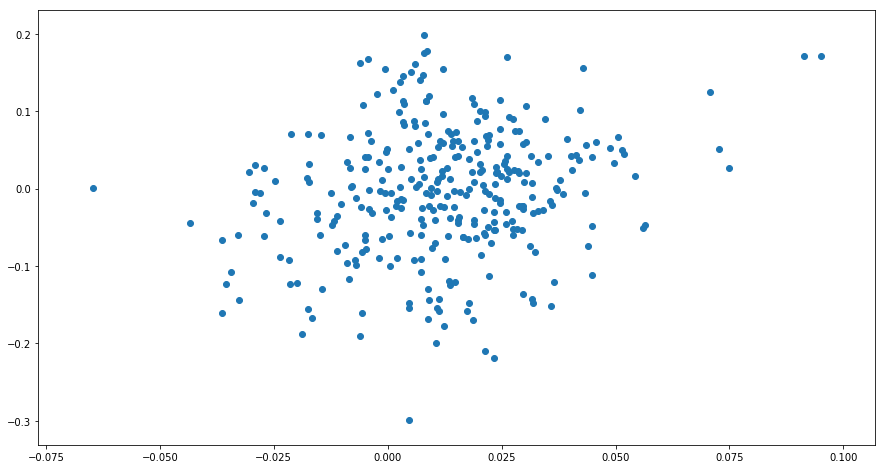

In [41]:
plt.scatter(reg.predict(X_test), y_test['log_ret_5'])

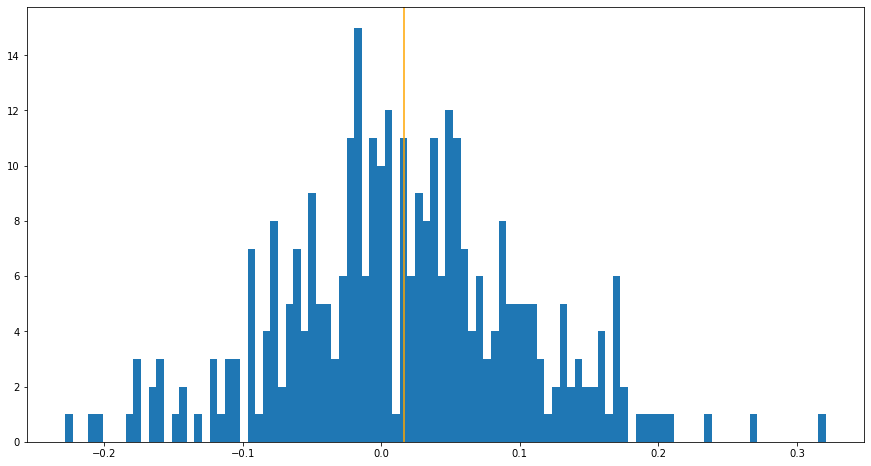

In [124]:
plt.hist(reg.predict(X_test)-y_test['log_ret_10'], bins=100)
plt.axvline(np.mean(reg.predict(X_test)-y_test['log_ret_5']), color='orange')
plt.show()